## 2. Build and Train Neural Network

In [31]:
# Installare tensorboard per visualizzare i dati e le learning curves del training
!pip install tensorboard

In [86]:
%load_ext tensorboard

In [248]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import datetime
import tensorflow as tf 

In [249]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [250]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [251]:
def draw_landmarks(image, results):
    #Per disegnare i punti della faccia decommentare la riga successiva
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) 
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    
    #Per disegnare i punti della mano sinistra decommentare la riga successiva
    #mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) 

In [252]:
def draw_styled_landmarks(image, results):
    
    #FACCIA
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
    #                         mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                         mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                         ) 

    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    #MANO SINISTRA
    #mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
    #                         mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
    #                         mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
    #                         ) 
    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [394]:
def extract_keypoints(results):
    
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    
    #lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    #Per inserire nell'array numpy tutti i landmarks, utilizzare il return della riga successiva
    #return np.concatenate([face, pose, lh, rh])
    return np.concatenate([rh, pose])

In [395]:
# Percorso dove è salvata la cartella dei segni
DATA_PATH = os.path.join('Nome_della_cartella') 

#Specificare i segni su cui effettuare il training 
signs = np.array(['Segno', 'Altro segno', '...'])

# Numero di acquisizioni per ogni segno - Inserire il numero totale di acquisizioni effettuate per ogni segno
no_sequences = 30

# Numero di frame per ogni acquisizione - Inserire il numero totale di frame acquisiti per ogni segno
sequence_length = 30 

#NOTA: Per poter effettuare il training:
#tutte le cartelle devono avere lo stesso numero di acquisizioni e ogni acquisizione deve avere lo stesso numero di frame 

## Preprocess Data and Create Labels and Features

In [396]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [397]:
label_map = {label:num for num, label in enumerate(signs)}

In [398]:
label_map

{'acqua': 0,
 'bere': 1,
 'bicchiere': 2,
 'rubinetto': 3,
 'birra alla spina': 4,
 'buon': 5,
 'caldo': 6,
 'cappuccino': 7,
 'ciao': 8,
 'caffe': 9,
 'cocacola': 10,
 'conto': 11,
 'cracker': 12,
 'desidera': 13,
 'destra': 14,
 'dica': 15,
 'dopo': 16,
 'euro': 17,
 'forno': 18,
 'freddo': 19,
 'fritte_frizzante': 20,
 'gelato': 21,
 'gomma da masticare': 22,
 'grazie': 23,
 'latte': 24,
 'limone': 25,
 'macchiato': 26,
 'mangiare': 27,
 'mi dia': 28,
 'mi dispiace': 29,
 'non': 30,
 'panino': 31,
 'patate': 32,
 'per favore': 33,
 'saluti': 34,
 'scusi': 35,
 'succo_di_frutta': 36,
 'tea': 37,
 'un': 38,
 'uomini': 39,
 'vino_rosso': 40,
 'wc': 41}

In [399]:
sequences, labels = [], []
for sign in signs:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, sign, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[sign])

In [400]:
np.array(sequences).shape

(7560, 30, 63)

In [401]:
np.array(labels).shape

(7560,)

In [402]:
X = np.array(sequences)

In [403]:
X.shape

(7560, 30, 63)

In [404]:
y = to_categorical(labels).astype(int)

In [405]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [406]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [407]:
X_train

array([[[ 4.00092900e-01,  7.83166409e-01, -7.30689644e-05, ...,
          4.96666700e-01,  6.24012411e-01, -5.01609817e-02],
        [ 4.03359711e-01,  7.76499569e-01, -7.28101950e-05, ...,
          4.93657261e-01,  6.26225233e-01, -7.03889132e-02],
        [ 4.00149018e-01,  7.79512405e-01, -7.10673630e-05, ...,
          4.94082630e-01,  6.23422205e-01, -5.04131839e-02],
        ...,
        [ 4.02624071e-01,  7.81415164e-01, -6.82125465e-05, ...,
          4.94792819e-01,  6.27910316e-01, -5.29985726e-02],
        [ 4.02588785e-01,  7.83375621e-01, -8.06616808e-05, ...,
          4.96742755e-01,  6.27102673e-01, -4.78054620e-02],
        [ 4.02636528e-01,  7.83483624e-01, -7.82666684e-05, ...,
          4.96292949e-01,  6.26859009e-01, -4.54448313e-02]],

       [[ 3.68128598e-01,  8.40988159e-01, -7.39589668e-05, ...,
          4.49655235e-01,  7.64380455e-01, -3.91300321e-02],
        [ 3.65940988e-01,  8.38564396e-01, -6.22844236e-05, ...,
          4.52435821e-01,  7.56808698e

In [408]:
y_test.shape

(2268, 42)

## Build and Train LSTM Neural Network


In [409]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [410]:
# Clear any logs from previous runs
#rm -rf 'Logs/'

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [411]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,63))) # Modificare il primo valore di input_shape in base al numero di
                                                                                   # frame acquisiti per ogni segno e il secondo valore in base alla
                                                                                   # dimensione dell'array numpy 
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(signs.shape[0], activation='softmax'))

In [412]:
res = [.7, 0.2, 0.1]

In [413]:
signs[np.argmax(res)]

'acqua'

In [414]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [415]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(X_train, y_train,  epochs=100, steps_per_epoch = 40, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/100
40/40 [==============================] - 13s 242ms/step - loss: 3.7237 - categorical_accuracy: 0.0340 - val_loss: 3.5669 - val_categorical_accuracy: 0.0317
Epoch 2/100
40/40 [==============================] - 8s 189ms/step - loss: 3.4873 - categorical_accuracy: 0.0652 - val_loss: 3.1554 - val_categorical_accuracy: 0.1296
Epoch 3/100
40/40 [==============================] - 8s 194ms/step - loss: 3.0183 - categorical_accuracy: 0.1501 - val_loss: 3.6370 - val_categorical_accuracy: 0.1235
Epoch 4/100
40/40 [==============================] - 8s 200ms/step - loss: 3.0371 - categorical_accuracy: 0.1473 - val_loss: 2.5862 - val_categorical_accuracy: 0.2165
Epoch 5/100
40/40 [==============================] - 8s 204ms/step - loss: 2.4168 - categorical_accuracy: 0.2562 - val_loss: 2.1603 - val_categorical_accuracy: 0.3131
Epoch 6/100
40/40 [==============================] - 8s 194ms/step - loss: 2.0282 - categorical_accuracy: 0.3411 - val_loss: 1.8447 - val_categorical_accuracy: 0.38

In [1]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [182]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 30, 64)            48896     
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 128)           98816     
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 42)                1386      
Total params: 204,746
Trainable params: 204,746
Non-trainable params: 0
________________________________________________

## Make Predictions

In [416]:
res = model.predict(X_test)

In [417]:
signs[np.argmax(res[0])]

'dopo'

In [418]:
signs[np.argmax(y_test[0])]

'dopo'

## Save Weights

In [419]:
model.save('modello_da_salvare.h5') # ---> CAMBIARE FILE
#model.save('segni_composti.h5')

## Evaluation using Confusion Matrix and Accuracy

In [239]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import tensorflow as tf

In [240]:
model = tf.keras.models.load_model('modello_da_caricare.h5') # ---> CABIARE FILE

In [420]:
yhat = model.predict(X_test)

In [421]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [422]:
ytrue

[16,
 32,
 11,
 12,
 17,
 5,
 16,
 40,
 3,
 20,
 31,
 18,
 33,
 36,
 29,
 13,
 15,
 17,
 13,
 33,
 13,
 25,
 1,
 23,
 10,
 36,
 29,
 16,
 17,
 29,
 19,
 36,
 2,
 0,
 23,
 17,
 22,
 14,
 39,
 6,
 28,
 5,
 1,
 9,
 28,
 19,
 38,
 19,
 24,
 39,
 25,
 37,
 13,
 9,
 18,
 8,
 39,
 36,
 20,
 2,
 0,
 18,
 29,
 35,
 8,
 32,
 18,
 9,
 30,
 28,
 18,
 7,
 6,
 23,
 30,
 35,
 9,
 1,
 10,
 13,
 0,
 15,
 36,
 37,
 32,
 4,
 39,
 18,
 3,
 30,
 4,
 30,
 29,
 19,
 7,
 3,
 22,
 24,
 3,
 38,
 0,
 35,
 3,
 27,
 40,
 4,
 28,
 4,
 28,
 14,
 7,
 30,
 1,
 21,
 35,
 18,
 29,
 32,
 21,
 25,
 30,
 14,
 19,
 23,
 37,
 41,
 33,
 17,
 31,
 0,
 32,
 15,
 34,
 37,
 27,
 14,
 16,
 24,
 1,
 15,
 32,
 26,
 4,
 11,
 41,
 27,
 33,
 39,
 29,
 15,
 19,
 19,
 1,
 26,
 37,
 39,
 25,
 10,
 16,
 41,
 12,
 0,
 3,
 22,
 19,
 32,
 3,
 34,
 2,
 32,
 21,
 35,
 13,
 39,
 19,
 5,
 32,
 8,
 40,
 37,
 2,
 32,
 39,
 20,
 24,
 0,
 21,
 31,
 27,
 7,
 7,
 36,
 13,
 9,
 21,
 19,
 5,
 20,
 30,
 10,
 34,
 24,
 40,
 23,
 29,
 9,
 25,
 27,
 29,
 37,

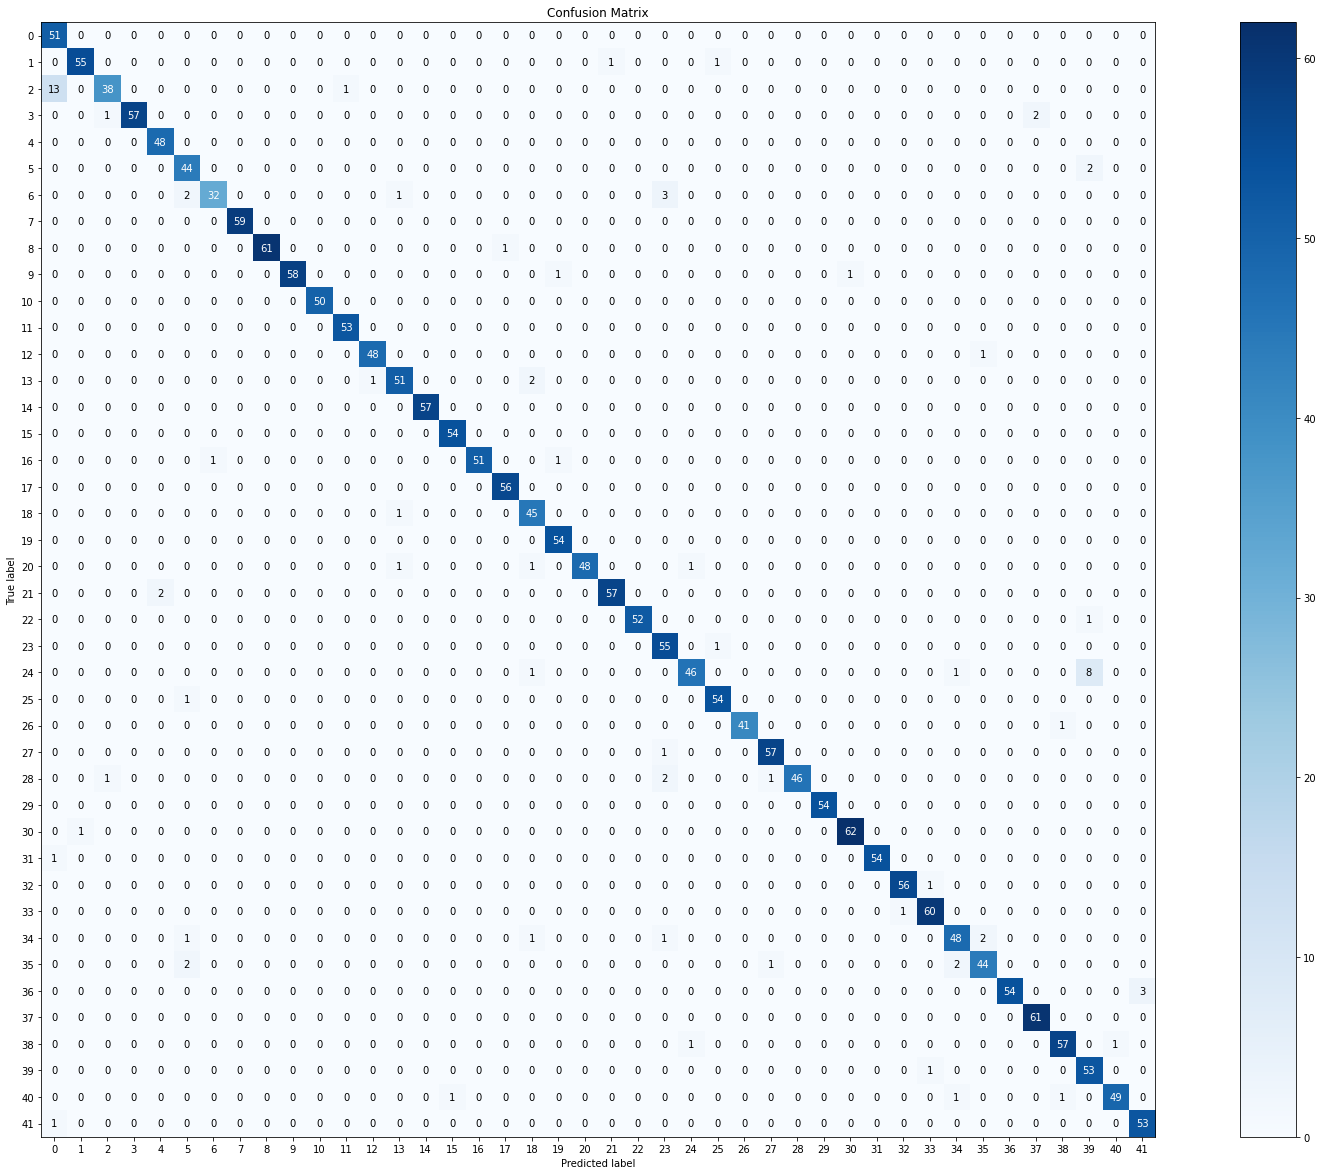

<Figure size 800x600 with 0 Axes>

In [425]:

import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


skplt.metrics.plot_confusion_matrix(ytrue, yhat)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(30.5, 20.5)
fig.savefig('test.png', dpi=100)

figure(figsize=(8, 6), dpi=100)

plt.show()

{'acqua': 0,
 'bere': 1,
 'bicchiere': 2,
 'rubinetto': 3,
 'birra alla spina': 4,
 'buon': 5,
 'caldo': 6,
 'cappuccino': 7,
 'ciao': 8,
 'caffe': 9,
 'cocacola': 10,
 'conto': 11,
 'cracker': 12,
 'desidera': 13,
 'destra': 14,
 'dica': 15,
 'dopo': 16,
 'euro': 17,
 'forno': 18,
 'freddo': 19,
 'fritte_frizzante': 20,
 'gelato': 21,
 'gomma da masticare': 22,
 'grazie': 23,
 'latte': 24,
 'limone': 25,
 'macchiato': 26,
 'mangiare': 27,
 'mi dia': 28,
 'mi dispiace': 29,
 'non': 30,
 'panino': 31,
 'patate': 32,
 'per favore': 33,
 'saluti': 34,
 'scusi': 35,
 'succo_di_frutta': 36,
 'tea': 37,
 'un': 38,
 'uomini': 39,
 'vino_rosso': 40,
 'wc': 41}

In [426]:
#Valore di accuratezza
accuracy_score(ytrue, yhat)

0.9625220458553791